## **Load the Preprocessed Data**

First, you need to import the required libraries and load the `preprocessed_data.csv` file that you saved earlier.

In [1]:
import pandas as pd
import numpy as np

# Load the preprocessed data
new_data = pd.read_csv(r"E:/Random Python Scripts/CICIDS/CICIDS2017/preprocessed_data.csv")

## **Creating a balanced dataset for Multi-Class Classification**

The following dataset is highly imbalanced, we took the help of **SMOTE (Synthetic Minority Over-sampling Technique)** to upsample the minority classes while creating a balanced dataset for multi-class classification. This helped us in creating an overall balanced dataset to feed the classification models.

In [2]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

Ensures a more balanced dataset by controlling the number of samples per class.

In [3]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

Attack Type
BENIGN         5000
DoS            5000
DDoS           5000
Port Scan      5000
Brute Force    5000
Web Attack     2143
Bot            1953
Name: count, dtype: int64

Combines the upsampled features and labels into a new DataFrame (`blnc_data`).

In [4]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
DDoS           5000
Port Scan      5000
BENIGN         5000
Web Attack     5000
Bot            5000
Brute Force    5000
DoS            5000
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

# **CNN**

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging 

# Enable logging
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

In [8]:
# One-Hot Encoding Labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))

In [9]:
# Reshape the dataset for CNN (assuming your data has 35 features)
def reshape_for_cnn(X):
    feature_count = X.shape[1]
    size = int(np.ceil(np.sqrt(feature_count)))  # Adjust size to fit square
    padded = np.zeros((X.shape[0], size ** 2))
    padded[:, :feature_count] = X
    reshaped = padded.reshape((padded.shape[0], size, size, 1))
    return reshaped

X_train_cnn = reshape_for_cnn(X_train.to_numpy())
X_test_cnn = reshape_for_cnn(X_test.to_numpy())

logging.info(f"Reshaped X_train: {X_train_cnn.shape}")
logging.info(f"Reshaped X_test: {X_test_cnn.shape}")

16:43:07 INFO Reshaped X_train: (26250, 6, 6, 1)
16:43:07 INFO Reshaped X_test: (8750, 6, 6, 1)


In [10]:
# Define CNN Model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
input_shape = X_train_cnn.shape[1:]  # Shape of one sample
num_classes = y_train_encoded.shape[1]  # Number of unique classes
cnn_model = create_cnn_model(input_shape, num_classes)

# Logging Model Summary
logging.info(cnn_model.summary())

C:\Users\Siddharth\anaconda3\envs\cicids\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 6, 6, 64)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,463 (1.54 MB)

 Trainable params: 403,463 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

16:43:07 INFO None


In [11]:
# Define Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("cnn_model_best.keras", monitor='val_accuracy', save_best_only=True)

In [12]:
# Train the model
history = cnn_model.fit(X_train_cnn, y_train_encoded,
                        validation_data=(X_test_cnn, y_test_encoded),
                        batch_size=128,
                        epochs=50,
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=1)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6605 - loss: 0.9374 - val_accuracy: 0.8675 - val_loss: 0.3613
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9312 - loss: 0.2305 - val_accuracy: 0.9205 - val_loss: 0.2530
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9466 - loss: 0.1715 - val_accuracy: 0.9519 - val_loss: 0.1517
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9586 - loss: 0.1292 - val_accuracy: 0.8319 - val_loss: 0.3905
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9466 - loss: 0.1621 - val_accuracy: 0.9562 - val_loss: 0.1143
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9666 - loss: 0.1064 - val_accuracy: 0.9656 - val_loss: 0.1058
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9683 - loss: 0.1001 - val_accuracy: 0.9667 - val_loss: 0.1157
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9699 - loss: 0.1012 - val

In [ ]:
# Save the final model
cnn_model.save("final_cnn_model.h5")
logging.info("Model saved as 'final_cnn_model.h5'")

In [ ]:
'''
import tensorflow as tf

# Load the trained CNN model
cnn_model = tf.keras.models.load_model("final_cnn_model.h5")
print("Model loaded successfully!")
'''

# **Performance Evaluation**

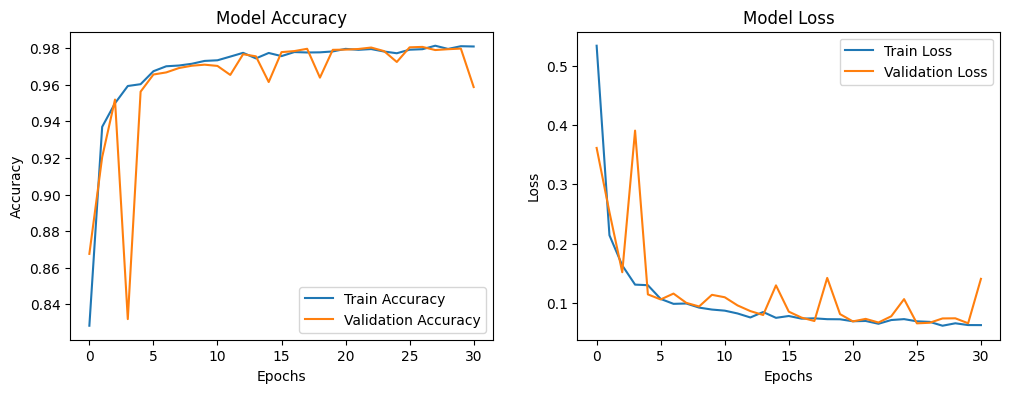

16:47:36 INFO Test Accuracy: 0.9805, Test Loss: 0.0655


In [13]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_encoded, verbose=0)
logging.info(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

In [14]:
# Predict on the test data
predictions = cnn_model.predict(X_test_cnn, verbose=1)

# Convert probabilities to class labels
predicted_classes = predictions.argmax(axis=1)

# Decode the one-hot encoded labels back to class names
true_classes = y_test_encoded.argmax(axis=1)
print("Predictions completed!")

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Predictions completed!


Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.91      0.95      1264
         Bot       0.97      1.00      0.98      1211
 Brute Force       0.99      0.98      0.98      1306
        DDoS       0.99      1.00      0.99      1206
         DoS       0.97      0.99      0.98      1240
   Port Scan       0.99      0.99      0.99      1275
  Web Attack       0.97      0.99      0.98      1248

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750



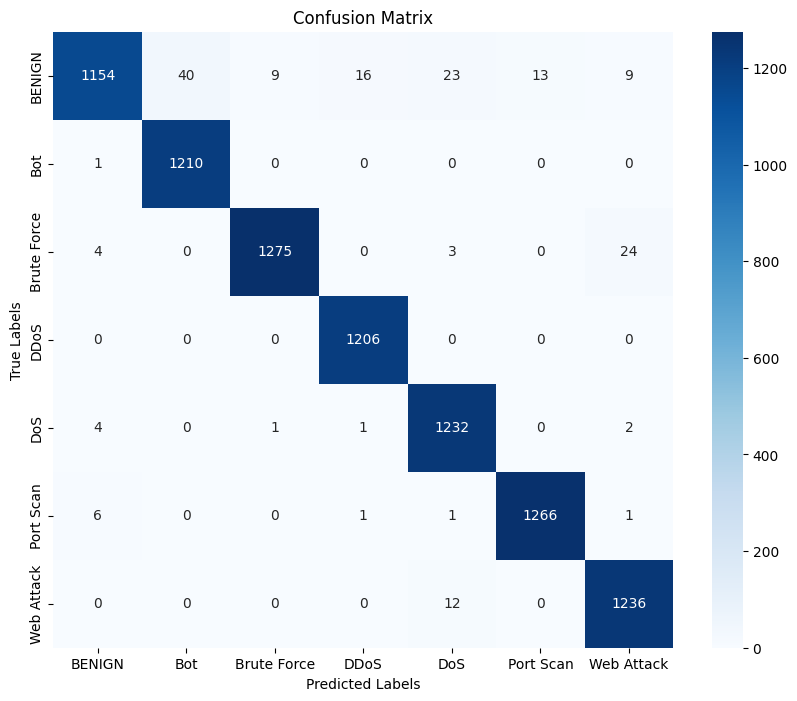

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=encoder.categories_[0])
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.categories_[0], 
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()